# the model

In [206]:
import duckdb
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

## get the data & preprocess (this should be part of the feature generation)

temporary: take the output from the sandbox as input for the model, with some preprocessing

in the future we will need to take the output of the feature generation

In [29]:
table = "sandbox_T_apartment_condo_S_ga_fl_nc_sc"

In [30]:
con = duckdb.connect('data/exploitation.db', read_only=True)
df = con.execute(f"select * from {table}").df()
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,hospital_type_children,government_hospital,nonprofit_hospital,private_hospital,num_schools,num_students,preschool,elementary_school,middle_school,high_school
0,7048425478,https://jacksonville.craigslist.org/apa/d/jack...,jacksonville,https://jacksonville.craigslist.org,779.0,apartment,628.0,1,1.0,Yes,...,68.0,68.0,680.0,272.0,19516,13155756.0,11016.0,2856.0,2788.0,2516.0
1,7048366147,https://jacksonville.craigslist.org/apa/d/jack...,jacksonville,https://jacksonville.craigslist.org,1712.0,apartment,1376.0,3,2.0,Yes,...,67.0,67.0,804.0,335.0,21708,14057873.0,12127.0,3149.0,3283.0,2747.0
2,7048295057,https://jacksonville.craigslist.org/apa/d/jack...,jacksonville,https://jacksonville.craigslist.org,1195.0,apartment,875.0,1,1.0,Yes,...,67.0,67.0,804.0,335.0,21708,14057873.0,12127.0,3149.0,3283.0,2747.0
3,7040827068,https://jacksonville.craigslist.org/apa/d/jack...,jacksonville,https://jacksonville.craigslist.org,730.0,apartment,800.0,3,1.0,Yes,...,21.0,21.0,231.0,84.0,6111,4213356.0,3528.0,903.0,903.0,672.0
4,7048272648,https://jacksonville.craigslist.org/apa/d/jack...,jacksonville,https://jacksonville.craigslist.org,835.0,apartment,865.0,2,1.0,Yes,...,25.0,25.0,225.0,100.0,7350,4927325.0,4150.0,1100.0,1150.0,825.0


In [31]:
df.loc[1:5, df.columns[20:50]]

,long,state,num_hospitals,num_beds,hospital_type_general,hospital_type_critical,hospital_type_psychiatric,hospital_type_longterm,hospital_type_children,government_hospital,nonprofit_hospital,private_hospital,num_schools,num_students,preschool,elementary_school,middle_school,high_school
1,-81.5571,fl,1340,324749.0,938.0,0.0,134.0,67.0,67.0,67.0,804.0,335.0,21708,14057873.0,12127.0,3149.0,3283.0,2747.0
2,-81.5571,fl,1340,324749.0,938.0,0.0,134.0,67.0,67.0,67.0,804.0,335.0,21708,14057873.0,12127.0,3149.0,3283.0,2747.0
3,-81.7219,fl,378,93072.0,273.0,0.0,42.0,0.0,21.0,21.0,231.0,84.0,6111,4213356.0,3528.0,903.0,903.0,672.0
4,-81.5882,fl,400,107525.0,275.0,0.0,50.0,0.0,25.0,25.0,225.0,100.0,7350,4927325.0,4150.0,1100.0,1150.0,825.0
5,-81.5831,fl,399,101262.0,273.0,0.0,42.0,21.0,21.0,21.0,231.0,105.0,6783,4450488.0,3738.0,1008.0,1029.0,882.0


In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [34]:
# select columns
y_col = 'price'
x_cols_binary = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished']
x_cols_numeric = [
    'sqfeet', 'beds', 'baths','lat', 'long','num_hospitals', 'num_beds', 'hospital_type_general', 'hospital_type_critical',
    'hospital_type_psychiatric', 'hospital_type_longterm', 'hospital_type_children','government_hospital', 'nonprofit_hospital',
    'num_schools', 'num_students', 'preschool', 'elementary_school', 'middle_school', 'high_school'
]
x_cols_onehot = ['type', 'state']

In [55]:
# make everything numeric and scaled
bin2num = lambda x: 1 if x=='Yes' or x==1 else 0
for col in x_cols_binary:
    df[col] = df[col].apply(bin2num)

# one-hot encoding in categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[x_cols_onehot])

cols_encoded = []
for i in range(len(x_cols_onehot)):
  col = x_cols_onehot[i]
  print("col: ", col)
  for name in enc.categories_[i]:
    cols_encoded.append(str(col+'_'+name[0:].strip()).lower().strip())
    print("name: ", str(col+'_'+name[0:].strip()).lower().strip())

df_onehot_encoded = pd.DataFrame(enc.transform(df[x_cols_onehot]).toarray(), columns = cols_encoded)

# scaling numerical variables:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[x_cols_numeric]), columns = x_cols_numeric)



col:  type
name:  type_apartment
name:  type_condo
col:  state
name:  state_fl
name:  state_ga
name:  state_nc
name:  state_sc


In [60]:
# columns in the one-hot encoding
print(enc.feature_names_in_)
print(enc.categories_)

# parameters used in the scaling
print(scaler.feature_names_in_)
print(scaler.mean_)
print(scaler.scale_)

['type' 'state']
[array(['apartment', 'condo'], dtype=object), array(['fl', 'ga', 'nc', 'sc'], dtype=object)]
['sqfeet' 'beds' 'baths' 'lat' 'long' 'num_hospitals' 'num_beds'
 'hospital_type_general' 'hospital_type_critical'
 'hospital_type_psychiatric' 'hospital_type_longterm'
 'hospital_type_children' 'government_hospital' 'nonprofit_hospital'
 'num_schools' 'num_students' 'preschool' 'elementary_school'
 'middle_school' 'high_school']
[ 9.84223378e+02  1.79741132e+00  1.54273948e+00  3.18642369e+01
 -8.15811439e+01  1.70425292e+03  3.06747154e+05  1.09551241e+03
  3.50580439e+01  2.56119804e+02  1.07602997e+02  1.62459862e+01
  3.01848380e+02  6.58471024e+02  2.17720920e+04  1.44034788e+07
  1.16194061e+04  3.73690539e+03  3.68354704e+03  2.11276928e+03]
[3.07145912e+03 7.68282029e-01 5.76197363e-01 3.07553778e+00
 2.20238276e+00 2.18703301e+03 3.95103187e+05 1.47594939e+03
 1.68850586e+02 4.15007224e+02 1.87917386e+02 4.71248516e+01
 4.90045193e+02 1.11855270e+03 2.86298554e+04 1.8

In [92]:
df_processed = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df_scaled, df[[y_col]]
], axis = 1
)

df_processed.fillna(0, inplace=True)

df_processed.head()

,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,type_apartment,type_condo,state_fl,state_ga,...,hospital_type_children,government_hospital,nonprofit_hospital,num_schools,num_students,preschool,elementary_school,middle_school,high_school,price
0,1,1,0,0,0,0,1.0,0.0,1.0,0.0,...,1.098232,-0.477198,0.019247,-0.078802,-0.068513,-0.038949,-0.176050,-0.169645,0.122671,779.0
1,1,1,1,1,0,0,1.0,0.0,1.0,0.0,...,1.077012,-0.479238,0.130105,-0.002239,-0.018977,0.032764,-0.117493,-0.075876,0.192946,1712.0
2,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,1.077012,-0.479238,0.130105,-0.002239,-0.018977,0.032764,-0.117493,-0.075876,0.192946,1195.0
3,1,1,0,0,0,0,1.0,0.0,1.0,0.0,...,0.100881,-0.573107,-0.382164,-0.547020,-0.559544,-0.522288,-0.566359,-0.526725,-0.438311,730.0
4,1,1,0,0,0,0,1.0,0.0,1.0,0.0,...,0.185762,-0.564945,-0.387528,-0.503743,-0.520340,-0.482139,-0.526988,-0.479935,-0.391765,835.0


In [97]:
# split training set and test set and validation set
df_train, df_val, df_test = np.split(
    df_processed.sample(frac=1, random_state=777),
    [ int(0.6*len(df_processed)) , int(0.8*len(df_processed)) ]
    )

X_train = df_train.drop(y_col, axis=1)
y_train = df_train[y_col]
X_val = df_val.drop(y_col, axis=1)
y_val = df_val[y_col]
X_test = df_test.drop(y_col, axis=1)
y_test = df_test[y_col]

## model training

In [130]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [136]:
def printMetrics(y_true, y_pred):
    print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print("MAE: ", metrics.mean_absolute_error(y_true, y_pred))
    print("MAPE: ", metrics.mean_absolute_percentage_error(y_true, y_pred))
    print("R2: ", metrics.r2_score(y_true, y_pred))

### option 1-1 - linear regression (without regularization)

In [98]:
reg = LinearRegression().fit(X_train, y_train)
yhat_train = reg.predict(X_train)
yhat_val = reg.predict(X_val)

In [101]:
reg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [100]:
reg.score(X_train, y_train)

0.0020204036713160622

In [102]:
reg.score(X_val, y_val)

-155.3391542691589

### option 1-2 - ridge regression
validation dataset to choose the regularization parameters NOOOOOO; it actually uses leave-one-out cross-validation

In [116]:
reg2 = RidgeCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

In [117]:
reg2.score(X_train, y_train)

0.0012965727874787447

In [118]:
yhat_train = reg2.predict(X_train)
yhat_val = reg2.predict(X_val)

In [119]:
reg2.get_params()

{'alpha_per_target': False,
 'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': 'deprecated',
 'scoring': None,
 'store_cv_values': False}

In [120]:
reg2.alpha_

1000.0

In [121]:
reg2.best_score_

-197974349809034.5

### option 1-3 - lasso regression

In [ ]:
reg3 = LassoCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

In [125]:
reg3.score(X_train, y_train)

0.0018141597699468104

In [126]:
yhat_train = reg3.predict(X_train)
yhat_val = reg3.predict(X_val)

In [127]:
reg3.get_params()

{'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [128]:
reg3.alpha_

1000.0

### option 2 - random forest

In [131]:
rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)

In [ ]:
yhat_train = rf.predict(X_train)
yhat_val = rf.predict(X_val)

In [137]:
printMetrics(y_train, yhat_train)

RMSE:  14049711.558335667
MAE:  337286.90687854425
MAPE:  2.9033665397045105e+18
R2:  0.0018141597699468104


In [138]:
printMetrics(y_val, yhat_val)

RMSE:  1412736.5554482955
MAE:  276141.73772523867
MAPE:  4.0819155273067965e+18
R2:  -90.51960177470649


In [135]:
max(y_train) # OUTLIERS!!!

2768307249.0

### option 3 - xgboost

#### without hyperparameter tunning

In [140]:
!pip install -U xgboost --quiet

In [141]:
import xgboost as xgb

In [181]:
param = {
    'objective':'reg:squarederror',
    'verbosity':1,
    'learning_rate':0.3,
    'max_depth':5,
    'subsample':0.8, # to avoid overfitting
    'reg_lambda':1, # L2 reg
    'alpha':0, #L1 reg
    'max_leaves':10
}
n_estim = 5

In [182]:
df_train

,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,type_apartment,type_condo,state_fl,state_ga,...,hospital_type_children,government_hospital,nonprofit_hospital,num_schools,num_students,preschool,elementary_school,middle_school,high_school,price
18536,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,-0.344743,-0.036422,-0.334782,-0.505035,-0.503950,-0.497953,-0.533983,-0.496037,-0.318752,1071.0
61516,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,-0.344743,0.257429,-0.397363,0.076700,-0.171562,-0.073160,-0.105303,-0.292397,1.440552,1229.0
6181,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,-0.302303,-0.599635,-0.560073,-0.725330,-0.747859,-0.716192,-0.719645,-0.667473,-0.599547,1234.0
48616,1,1,0,0,0,0,1.0,0.0,1.0,0.0,...,-0.344743,-0.615960,1.106366,0.862034,1.009633,0.922565,0.200469,0.619150,1.568324,1110.0
10990,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,-0.005220,-0.550660,-0.417031,-0.575486,-0.601136,-0.561017,-0.586943,-0.546237,-0.438311,1275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35771,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,4.854212,0.383947,0.068418,1.147854,1.056486,1.084453,0.820008,0.648133,1.965939,1470.0
27172,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,-0.344743,-0.418019,-0.501962,-0.404721,-0.528655,-0.462000,-0.475427,-0.514033,0.242533,602.0
6668,1,1,1,0,0,0,1.0,0.0,1.0,0.0,...,-0.344743,1.947069,-0.027241,1.564657,1.321471,1.033589,1.512291,1.086669,4.133507,1219.0
20005,1,1,1,1,0,0,1.0,0.0,1.0,0.0,...,-0.344743,0.298241,-0.188164,0.334892,-0.021331,0.247646,-0.075325,0.023575,1.606047,1179.0


In [183]:
data_train = xgb.DMatrix(X_train, label=y_train)
data_val = xgb.DMatrix(X_val, label=y_val)

In [184]:
time0 = time()
xgb_1 = xgb.train(param, data_train, n_estim)
print(time()-time0)

0.2563045024871826


In [185]:
yhat_train = xgb_1.predict(data_train)
yhat_val = xgb_1.predict(data_val)

In [186]:
printMetrics(y_train, yhat_train)

RMSE:  6239888.978598796
MAE:  33132.629729354434
MAPE:  1.7188204950688638e+16
R2:  0.8031069829694033


In [187]:
printMetrics(y_val, yhat_val)

RMSE:  155101.2718094486
MAE:  3333.7563209515974
MAPE:  2.535911175510825e+16
R2:  -0.10311927660701059


In [188]:
from xgboost import plot_importance, plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

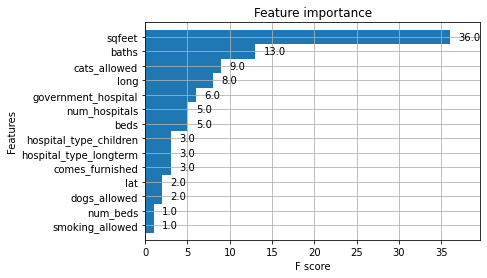

In [189]:
plot_importance(xgb_1, max_num_features = 30, height = 1)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

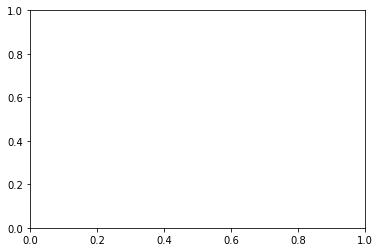

In [190]:
xgb.plot_tree(xgb_1, num_trees = 1, rankdir="LR") # FIX THIS!

#### with hyperparameter tunning

In [191]:
from sklearn.model_selection import GridSearchCV

In [192]:
params = {
    #'objective':'reg:squarederror',
    #'verbosity':1,
    'learning_rate':[0.1, 0.3, 1],
    'max_depth':[5, 7, 10],
    'subsample':[0.8], # to avoid overfitting
    'reg_lambda':[0, 0.1, 1], # L2 reg
    'alpha':[0, 0.1, 1], #L1 reg
    'max_leaves':[10],
    'n_estimators':[5, 10, 20]
}


In [205]:
xgbr = xgb.XGBRegressor(seed = 20, objective = 'reg:squarederror', verbosity = 1)

time0 = time()
xgb_grid = GridSearchCV(estimator=xgbr, param_grid = params, cv = 3)
xgb_grid.fit(X_train, y_train)
# retrain with the best parameters:
xgb_cv = xgb.train(xgb_grid.best_params_, data_train, xgb_grid.best_params_['n_estimators'])

print(time()-time0) # time ~ 443s

[19:20:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

404.2847113609314


In [196]:
"""{'alpha': 1,
 'learning_rate': 1,
 'max_depth': 5,
 'max_leaves': 10,
 'n_estimators': 10,
 'reg_lambda': 0.1,
 'subsample': 0.8}"""
xgb_grid.best_params_

{'alpha': 1,
 'learning_rate': 1,
 'max_depth': 5,
 'max_leaves': 10,
 'n_estimators': 10,
 'reg_lambda': 0.1,
 'subsample': 0.8}

In [198]:
yhat_train_xgbcv = xgb_grid.predict(X_train)
yhat_val_xgbcv = xgb_grid.predict(X_val)

In [202]:
printMetrics(y_train, yhat_train_xgbcv)
print("")
printMetrics(y_val, yhat_val_xgbcv)

RMSE:  55404.85833176817
MAE:  1333.4703565544428
MAPE:  1.7213169419225608e+16
R2:  0.9999844771205103

RMSE:  168028.39710675756
MAE:  3585.139705023948
MAPE:  2.1871162566076084e+16
R2:  -0.2946641574648634


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

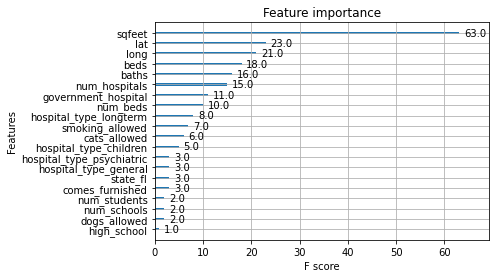

In [207]:
plot_importance(xgb_cv, max_num_features=20)

# plots

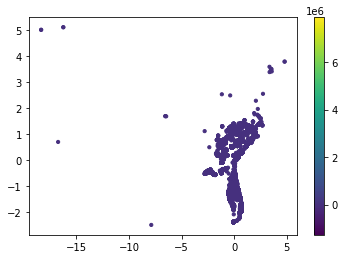

In [214]:
plt.scatter(X_train.long, X_train.lat, c=y_train-yhat_train_xgbcv, s=10)
plt.colorbar()

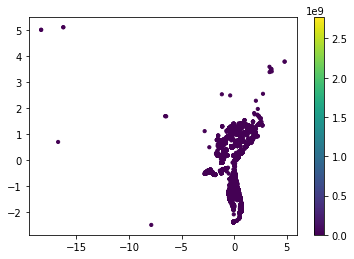

In [215]:
plt.scatter(X_train.long, X_train.lat, c=y_train, s=10)
plt.colorbar()